## ATE and CATE with Neural Network

As we'd done using Random Forest and XGBoost, we compute the average treatment effects using Neural Network. In other words, we let 
$$Y = f(D,X) + \varepsilon$$
 where $\mathbb{E}(\varepsilon|D,X) = 0$ and estimate $f$ by
$$
\hat{\mathbb{E}}(f(D,X)|D=1) = \frac{1}{n}\sum_{i=1}^n\hat{f}(1,x_i)
$$
where $\hat{f}$ is estimated by Neural Network.

Also, defining $X=(V,W)$, and
$$
Y = f(D,V,W) + \varepsilon
$$
with $\mathbb{E}(\varepsilon|D,X)=0$, We obtain the ATE with contingent variable $V$ from
$$
\mathbb{E}(f(D,V,W)|D=1,V=v) = \mathbb{E}(f(1,V,W)|V=v) \approx \frac{\sum_{i=1}^n\hat{f}(1,v_i,w_i)K(\frac{v-v_i}{h})}{\sum_{i=1}^nK(\frac{v-v_i}{h})}
$$
where $\hat{f}$ is estimated by Neural Network. As before, $V$ is given by either log household income or individual age. Here, Gaussian kernel density function with bandwidth parameter 1 has been used. Ideally, the bandwidth parameter should be chosen more carefully.

In [1]:
# Import data
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import numba
from numba import jit
from functions import *
import plotly.graph_objects as go
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm 
from IPython.display import display, HTML
import plotly
import tensorflow as tf
import random
import sqlite3
import os
X_used, Y = get_data(42)
n = X_used.shape[0]

X_used_cnst = sm.add_constant(X_used)
model = sm.OLS(Y,X_used_cnst)
results = model.fit()
# results.summary()

In [2]:
h = 1  # Bandwidth parameter
grid_size = 20

a_grid = np.linspace(np.min(X_used.age), np.max(X_used.age), grid_size)
w_grid = np.linspace(np.min(X_used.hh_inc), np.max(X_used.hh_inc), grid_size)
xv, wv = np.meshgrid(a_grid, w_grid, indexing='ij')

weights_w = np.zeros((n, grid_size))
for i in range(grid_size):
    u = np.abs(X_used['hh_inc'].values - w_grid[i])/h
    val = Gaussian(u)
    weights_w[:,i] = val/np.sum(val)

h = 1  # Bandwidth parameter
weights_a = np.zeros((n, grid_size))
for i in range(grid_size):
    u = np.abs(X_used['age'].values - a_grid[i])/h
    val = Gaussian(u)
    weights_a[:,i] = val/np.sum(val)

# characteristic_names = ['zerotofive','sixtotwenty','grp','home_own','gender','isHHH',
#                         'live_together','college_educ','work','get_social_benefit',
#                         'got_social_benefit','religion','marriage','health','health','health',
#                         'exercise','exercise','exercise','smoke','alcohol']

# ATE_names = ['zerotofive','sixtotwenty','grp','home_own','gender','isHHH',
#                         'live_together','college_educ','work','get_social_benefit',
#                         'got_social_benefit','religion','marriage','health1','health2','health3',
#                         'exercise1','exercise2','exercise3','smoke','alcohol']

# positives = [1,1,1,1,1,1,1,1,1,1,1,1,1,5,5,2,3,3,1,1,1]
# negatives = [0,0,0,0,0,0,0,0,0,0,0,0,0,1,4,1,0,2,0,0,0]
# plot_names = ['Baby - No Baby', 'Teenager - No Teenager', 'Grandparents - No Grandparents','Homeowner - Lease',
#               'Female - Male', 'Head - Not Head', 'Live Together - Separate', 'College Education - No College Education',
#               'Work - No Work','Receive Social Insurance - Has Never Received', 'Had Received Social Insurance - Has Never Received',
#               'Religion - No Religion','Married - Not Married', 'Very Healty (5) - Very Unhealty (1)','Very Healty (5) - Healty (4)',
#               'Unhealty (2) - Very Unhealty (1)','Exercise regularly - No Exercise','Exercise regularly - Exercise irregularly',
#               'Almost No Exercise - No Exercise', 'Smoke - No Smoke', 'Alcohol - No Alcohol']

characteristic_names = ['zerotofive','gender','live_together','marriage','health',
                        'exercise','smoke','alcohol']
ATE_names = characteristic_names
positives = [1,1,1,1,5,3,1,1]
negatives = [0,0,0,0,1,0,0,0]
plot_names = ['Baby - No Baby', 'Female - Male', 'Live Together - Separate', 'Married - Not Married',
               'Very Healty (5) - Very Unhealty (1)',
              'Exercise regularly - No Exercise', 'Smoke - No Smoke', 'Alcohol - No Alcohol']

In [3]:
param = np.array([40, 20, 10])

model_FF = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(X_used.shape[1],)),
        tf.keras.layers.Dense(param[0], activation="relu"),
        tf.keras.layers.Dense(param[1], activation="relu"),
        tf.keras.layers.Dense(param[2], activation="relu"),
        tf.keras.layers.Dense(1)
    ]
)
model_FF.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 40)                  │             960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 20)                  │             820 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             210 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,001 (7.82 KB)

 Trainable params: 2,001 (7.82 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
seed_list = [42, 43, 44, 45, 46]
# seed_list = [42, 43]
batch_size = X_used.shape[0]
epochs = 500
param = np.array([40, 20, 10])
ATE_all = {}
model_FF_tot = {}
t = time.time()
for seed in seed_list:
    for j,char_name in enumerate(characteristic_names):
        
        tf.random.set_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        
        model_FF = tf.keras.Sequential(
            [
                tf.keras.Input(shape=(X_used.shape[1],)),
                tf.keras.layers.Dense(param[0], activation="relu"),
                tf.keras.layers.Dense(param[1], activation="relu"),
                tf.keras.layers.Dense(param[2], activation="relu"),
                tf.keras.layers.Dense(1)
            ]
        )
        
        model_FF.compile(loss=tf.keras.losses.MeanSquaredError(),
                    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2))
        
        model_FF.fit(X_used, Y, batch_size=batch_size, epochs=epochs, verbose=0)
        model_FF_tot[seed, j] = model_FF
        
        x_fix_1 = X_used.copy()
        x_fix_0 = X_used.copy()
        x_fix_1[char_name] = positives[j]
        x_fix_0[char_name] = negatives[j]
        val_1_FF = np.mean(model_FF.predict(x_fix_1,verbose=0))
        val_0_FF = np.mean(model_FF.predict(x_fix_0,verbose=0))
        ATE_all[ATE_names[j],seed] = val_1_FF-val_0_FF
elapsed = time.time() - t
print('elapsed time = %0.2f sec; %s'%(elapsed, datetime.datetime.now()))

elapsed time = 797.34 sec; 2024-08-23 11:32:10.324352


In [5]:
ATE_all_pd = pd.Series(ATE_all).reset_index()
ATE_all_pd_pivot = ATE_all_pd.pivot(index = ['level_0'], columns='level_1',values=0)
ATE_all_pd_pivot

level_1,42,43,44,45,46
level_0,,,,,
alcohol,-0.026609,-0.027894,-0.034471,-0.042912,-0.031684
exercise,0.327795,0.349476,0.342548,0.332113,0.327565
gender,0.182672,0.170520,0.157368,0.153009,0.161231
health,1.271834,1.381061,1.428020,1.433760,1.292531
live_together,0.082571,0.188584,0.083493,0.083974,0.027256
marriage,0.428465,0.419308,0.396262,0.363098,0.403431
smoke,-0.186916,-0.202214,-0.211558,-0.219789,-0.218504
zerotofive,0.122666,0.105188,0.110878,0.114140,0.087080


In [6]:
CATE_all_w = {}
t = time.time()
for seed in seed_list:
    for j,char_name in enumerate(characteristic_names):
        print(char_name)
        val_1_FF = np.zeros((grid_size,))
        val_0_FF = np.zeros((grid_size,))
        for i in range(grid_size):
            x_fix_1 = X_used.copy()
            x_fix_0 = X_used.copy()
            x_fix_1['hh_inc'] = w_grid[i]
            x_fix_0['hh_inc'] = w_grid[i]
            x_fix_1[characteristic_names[j]] = positives[j]
            x_fix_0[characteristic_names[j]] = negatives[j]
            val_1_FF[i] = np.sum(weights_w[:,i]*model_FF_tot[seed,j].predict(x_fix_1,verbose=0).reshape(-1,))
            val_0_FF[i] = np.sum(weights_w[:,i]*model_FF_tot[seed,j].predict(x_fix_0,verbose=0).reshape(-1,))
        CATE_all_w[seed,char_name] = val_1_FF-val_0_FF
elapsed = time.time() - t
print('elapsed time = %0.2f sec; %s'%(elapsed, datetime.datetime.now()))


zerotofive
gender
live_together
marriage
health
exercise
smoke
alcohol
zerotofive
gender
live_together
marriage
health
exercise
smoke
alcohol
zerotofive
gender
live_together
marriage
health
exercise
smoke
alcohol
zerotofive
gender
live_together
marriage
health
exercise
smoke
alcohol
zerotofive
gender
live_together
marriage
health
exercise
smoke
alcohol
elapsed time = 553.80 sec; 2024-08-23 11:41:24.162889


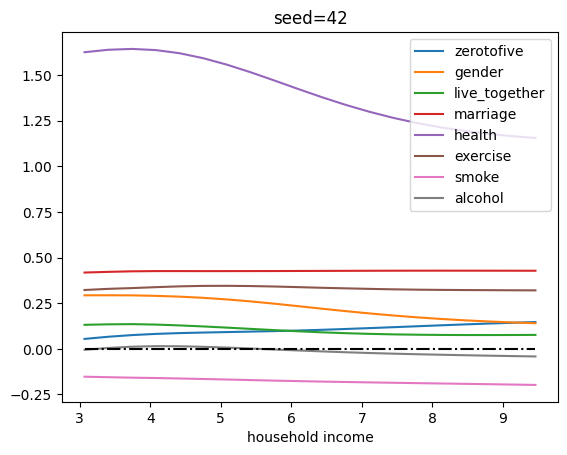

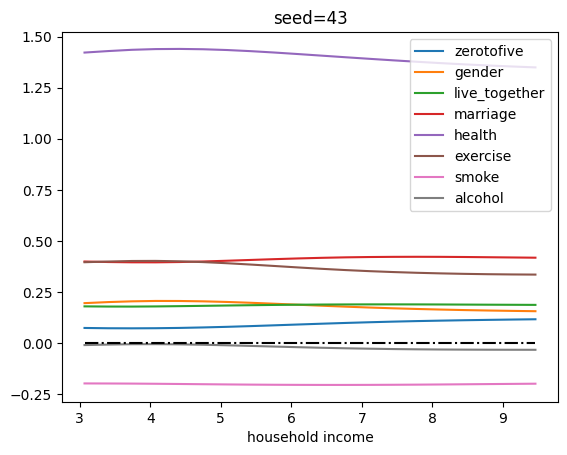

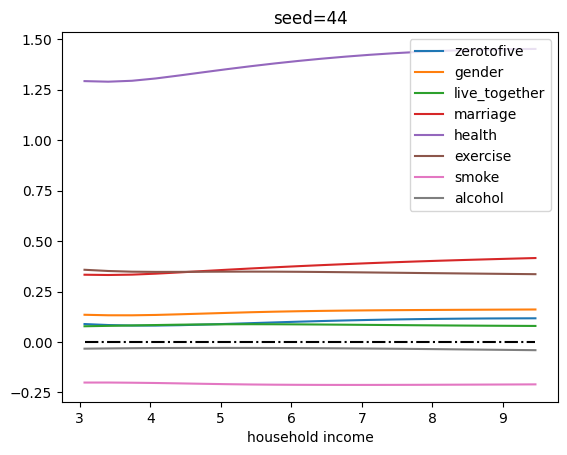

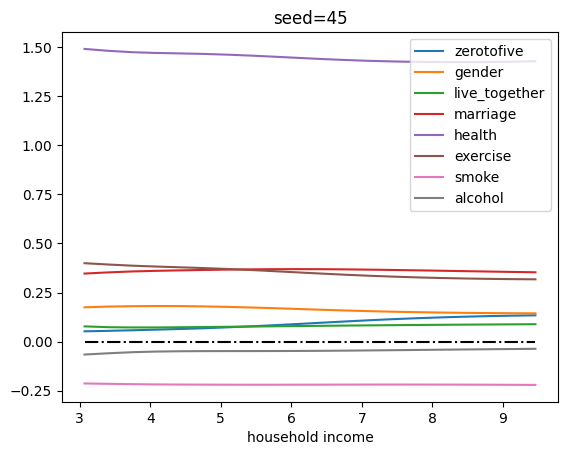

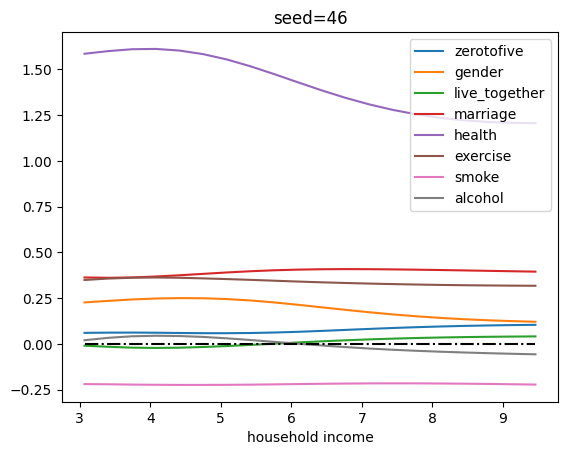

In [25]:
CATE_all_w_pd = pd.DataFrame(CATE_all_w).T.reset_index()
for seed in seed_list:
    plt.plot(w_grid,CATE_all_w_pd.query("level_0==%i"%seed).values[:,2:].T)
    plt.plot(w_grid,np.zeros((w_grid.shape[0],)),'k-.')
    plt.title('seed=%i'%seed)
    plt.legend(characteristic_names)
    plt.xlabel('household income')
    plt.show()

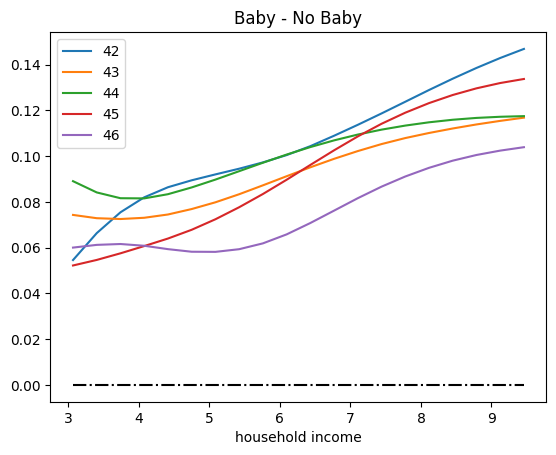

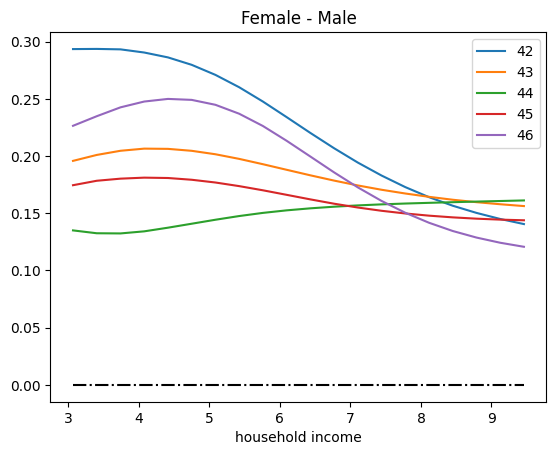

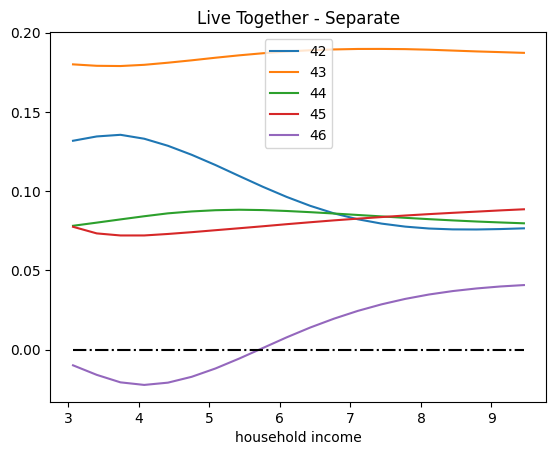

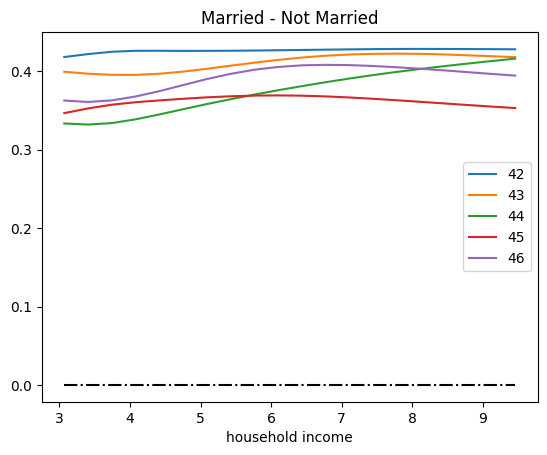

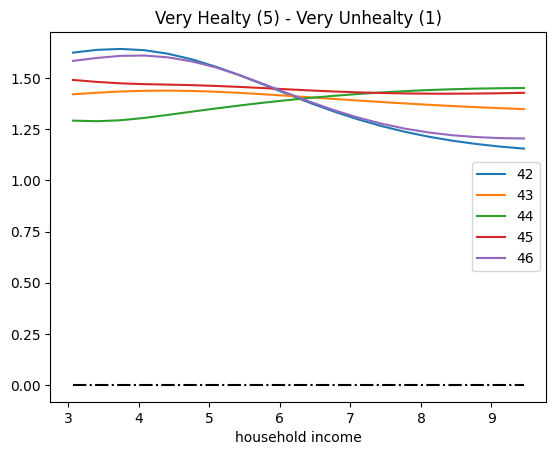

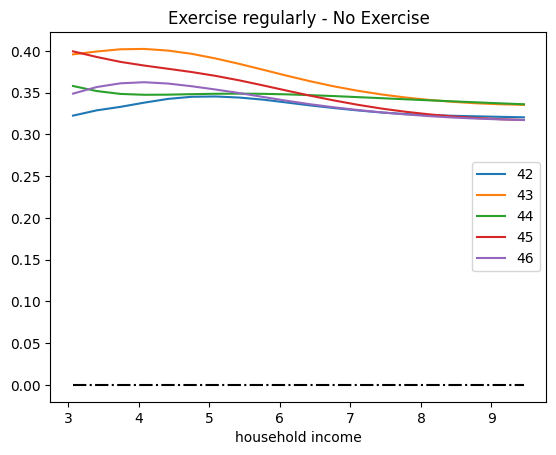

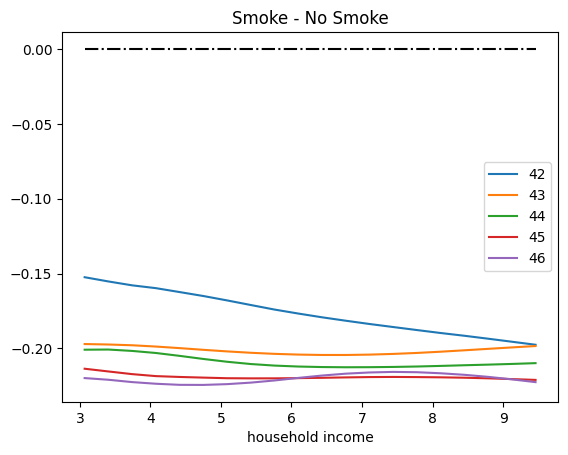

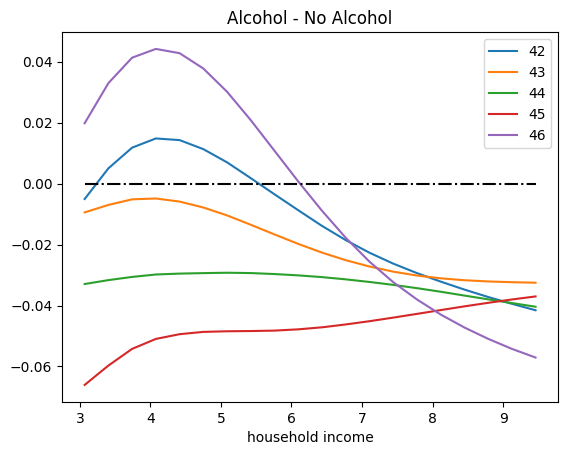

In [16]:
CATE_all_w_pd = pd.DataFrame(CATE_all_w).T.reset_index()
for j,char_name in enumerate(characteristic_names):
    plt.plot(w_grid,CATE_all_w_pd.query("level_1=='%s'"%char_name).values[:,2:].T)
    plt.plot(w_grid,np.zeros((w_grid.shape[0],)),'k-.')
    plt.title(plot_names[j])
    plt.legend(seed_list)
    plt.xlabel('household income')
    plt.show()

In [8]:
CATE_all_a = {}
t = time.time()
for seed in seed_list:
    for j,char_name in enumerate(characteristic_names):
        print(char_name)
        val_1_FF = np.zeros((grid_size,))
        val_0_FF = np.zeros((grid_size,))
        for i in range(grid_size):
            x_fix_1 = X_used.copy()
            x_fix_0 = X_used.copy()
            x_fix_1['age'] = a_grid[i]
            x_fix_0['age'] = a_grid[i]
            x_fix_1[characteristic_names[j]] = positives[j]
            x_fix_0[characteristic_names[j]] = negatives[j]
            val_1_FF[i] = np.sum(weights_a[:,i]*model_FF_tot[seed,j].predict(x_fix_1,verbose=0).reshape(-1,))
            val_0_FF[i] = np.sum(weights_a[:,i]*model_FF_tot[seed,j].predict(x_fix_0,verbose=0).reshape(-1,))
        CATE_all_a[seed,char_name] = val_1_FF-val_0_FF
elapsed = time.time() - t
print('elapsed time = %0.2f sec; %s'%(elapsed, datetime.datetime.now()))


zerotofive
gender
live_together
marriage
health
exercise
smoke
alcohol
zerotofive
gender
live_together
marriage
health
exercise
smoke
alcohol
zerotofive
gender
live_together
marriage
health
exercise
smoke
alcohol
zerotofive
gender
live_together
marriage
health
exercise
smoke
alcohol
zerotofive
gender
live_together
marriage
health
exercise
smoke
alcohol
elapsed time = 541.75 sec; 2024-08-23 11:50:27.271587


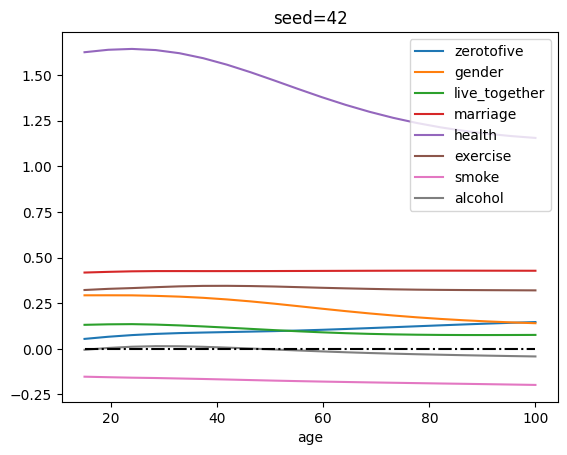

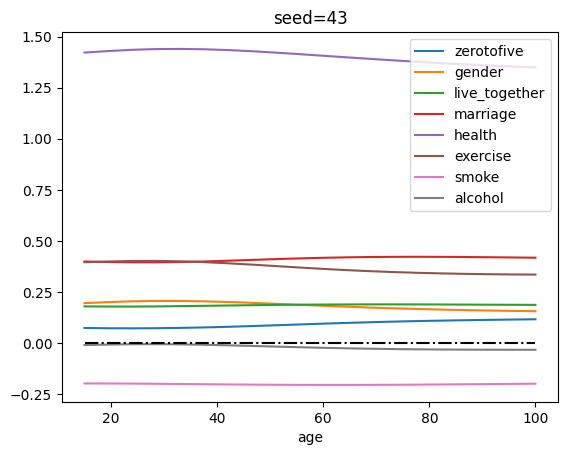

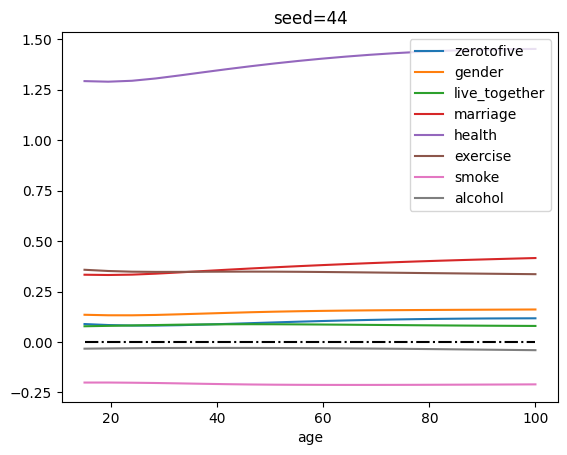

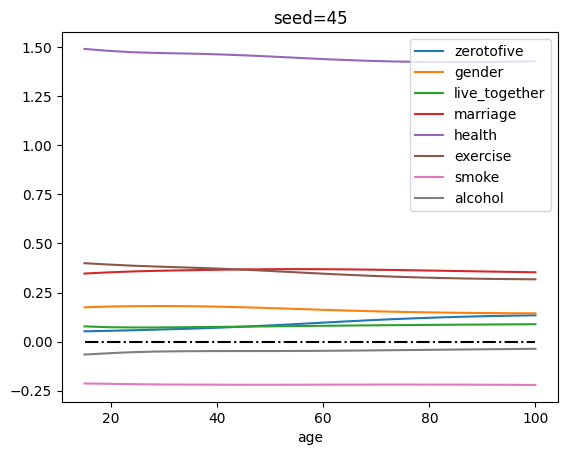

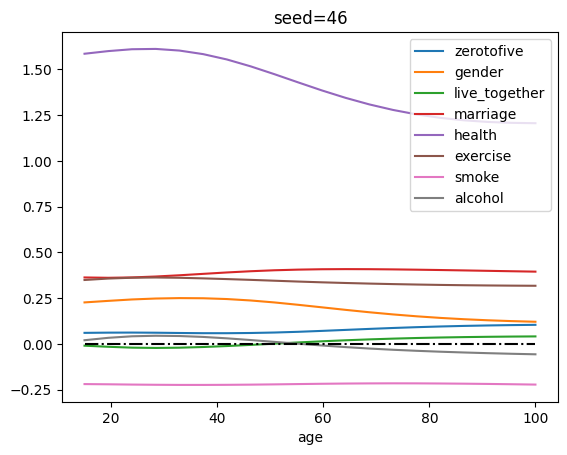

In [26]:
CATE_all_a_pd = pd.DataFrame(CATE_all_a).T.reset_index()
for seed in seed_list:
    plt.plot(a_grid,CATE_all_w_pd.query("level_0==%i"%seed).values[:,2:].T)
    plt.plot(a_grid,np.zeros((w_grid.shape[0],)),'k-.')
    plt.title('seed=%i'%seed)
    plt.legend(characteristic_names)
    plt.xlabel('age')
    plt.show()

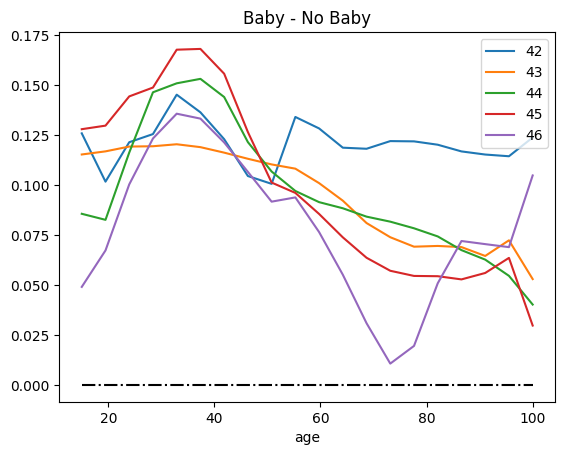

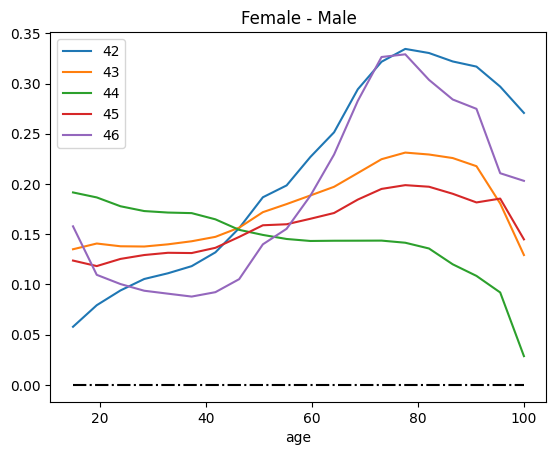

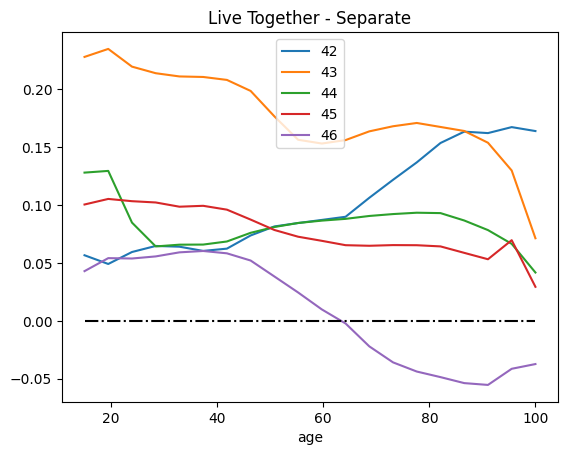

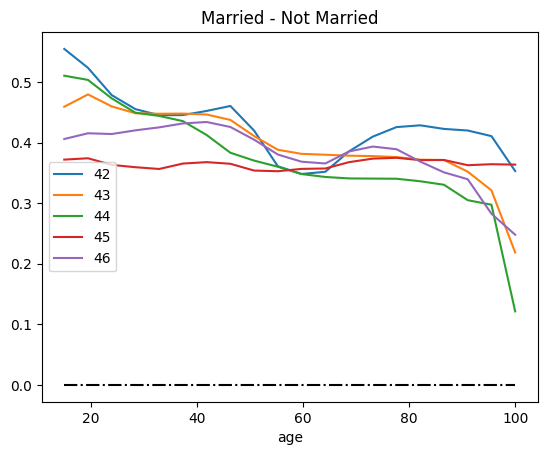

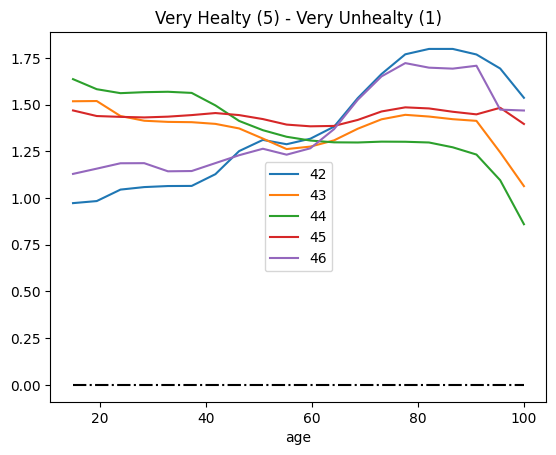

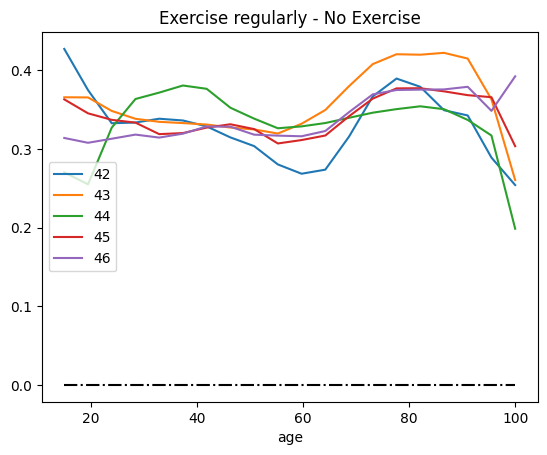

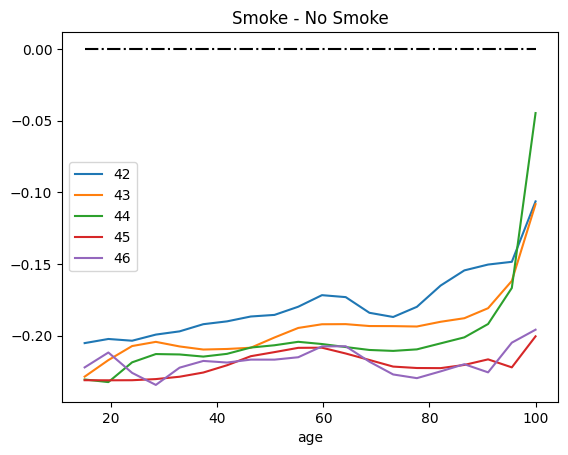

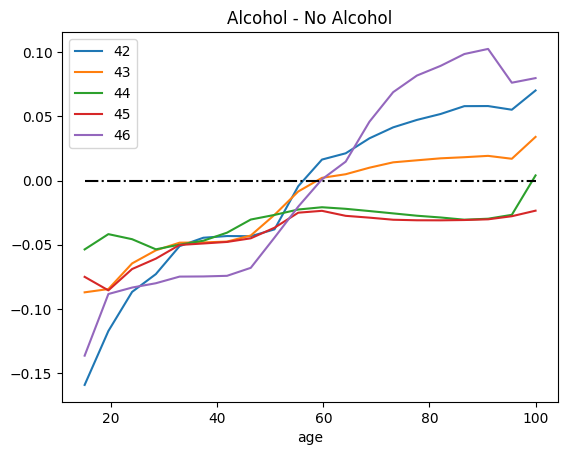

In [15]:
CATE_all_a_pd = pd.DataFrame(CATE_all_a).T.reset_index()
for j,char_name in enumerate(characteristic_names):
    plt.plot(a_grid,CATE_all_a_pd.query("level_1=='%s'"%char_name).values[:,2:].T)
    plt.title(plot_names[j])
    plt.plot(a_grid,np.zeros((w_grid.shape[0],)),'k-.')
    plt.legend(seed_list)
    plt.xlabel('age')
    plt.show()